# MWLR Pipeline: Visualisation

### Imports

In [5]:
from IPython.core.display import display, HTML, Markdown as md
display(HTML("""<style>.container { width:80% !important; } p, ul {max-width:␣
,→40em;} .rendered_html table { margin-left: 0; } .output_subarea.output_png {␣
,→display: flex; justify-content: center;}</style>"""))

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

import os

from   datetime              import datetime
from   datetime              import timedelta

import spacy
import en_core_web_lg
nlp_lg = spacy.load('en_core_web_lg')

from pylab           import rcParams
from sklearn         import metrics
from sklearn.metrics import plot_confusion_matrix

### Functions

In [6]:
def roundTime(dt=datetime.now(), roundTo=60):
   
   seconds  = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo

   return dt + timedelta(0,rounding-seconds,-dt.microsecond)

### Script

In [7]:
# Directory information
date      = datetime.now()
day, time = str(roundTime(date, 10*60)).split(' ')
rootDir   = 'Results\\' + day 
rootDir   = rootDir + '\\' + next(os.walk(rootDir))[1][-1]

# Set specific folders
featuresFolder  = rootDir + '\\Features'
confusionFolder = rootDir + '\\ConfusionMatrices'
metricsFolder   = rootDir + '\\IndividualMetrics'
resultsFolder   = rootDir + '\\Results'
graphsFolder    = rootDir + '\\Graphs'
GISFolder       = rootDir + '\\GISPaper'

# What ever's being done uses the keyword 'list' so we have to start with this line
if 'list' in locals():
    del list

# Then we do some data visualization parameters
%matplotlib inline
rcParams['figure.figsize']  = 15, 10
rcParams['axes.titlesize']  = 20
rcParams['axes.labelsize']  = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size']       = 18

# Now we get the working data set
relations                  = pd.read_csv('Metrics\\DataSet\\workingDataset.csv', index_col = 0, dtype = {'Tagged_Relationship': 'int8'})
col_to_downcast            = [col for col in relations.columns if relations[col].dtype == int]
relations[col_to_downcast] = relations[col_to_downcast].apply(pd.to_numeric, downcast='integer')

# Now we modify the columns for some reason
cols                       = list(relations.columns)
cols.remove('Tagged_Relationship')
cols.append('Tagged_Relationship')
relations = relations[cols]

# Create a summary of all documents
DocNum                 = []
Name                   = []
Possible_Relationships = []
TrueRelationships      = []
LengthTokens           = []
LengthChars            = []
SpeciesMentions        = []
UniqueSpecies          = []
LocationMentions       = []
UniqueLocations        = []
Sentences              = []
SpeciesTokens          = []
LocationTokens         = []

# Now we iterate through each unique document in the dataset
for i, txtFile in enumerate(relations.AnnTxtFile.unique(), 1):
    
    # We get the actual PDF document name
    document = relations.loc[i, 'Document']
    DocNum.append('Document ' + str(i))
    
    # Append it to the thing
    Name.append(document)
    
    # Extract our data for the unique PDF
    Possible_Relationships.append(len(relations[relations.Document  == document]))
    TrueRelationships.append     (len(relations[(relations.Document == document) & (relations.Tagged_Relationship == 1)]))
    SpeciesMentions.append       (len(relations[relations.Document  == document]['Start_Token_Species'].unique()))
    UniqueSpecies.append         (len(relations[relations.Document  == document]['Species'].unique()))
    UniqueLocations.append       (len(relations[relations.Document  == document]['Location'].unique()))
    LocationMentions.append      (len(relations[relations.Document  == document]['Start_Token_Location'].unique()))
    
    # Read in the associated extracted text file
    file     = open(txtFile,  encoding = "utf-8")
    textfile = file.read()
    file.close()
    
    # Extract more data
    LengthChars.append(len(textfile))
    doc = nlp_lg(textfile)
    LengthTokens.append(len(doc))
    Sentences.append(len([1 for sent in doc.sents]))
    SpeciesTokens.append(relations[relations.Document  == document]['End_Token_Species'].unique().sum() - 
                         relations[relations.Document  == document]['Start_Token_Species'].unique().sum())
    LocationTokens.append(relations[relations.Document == document]['End_Token_Location'].unique().sum() - 
                         relations[relations.Document  == document]['Start_Token_Location'].unique().sum())

# Append the total of all documents we worked with
DocNum.append('Total')
for list in [Possible_Relationships, 
             TrueRelationships, 
             LengthTokens, 
             LengthChars, 
             SpeciesMentions, 
             UniqueSpecies, 
             LocationMentions, 
             UniqueLocations, 
             Sentences, 
             SpeciesTokens, 
             LocationTokens]:
    list.append(sum(list))

# Avoid devision by zero
RelationshipPerc = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(TrueRelationships,Possible_Relationships)]
SpeciesPerc      = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(SpeciesTokens,LengthTokens)]
LocationPerc     = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(LocationTokens,LengthTokens)]

# Then put it all in a summary dataframe
Summary = pd.DataFrame({'DocNum'                 : DocNum,
                        'Sentences'              : Sentences, 
                        'Tokens'                 : LengthTokens, 
                        'Characters'             : LengthChars,
                        'Species Mentions'       : SpeciesMentions, 
                        'Species %'              : SpeciesPerc, 
                        'Location Mentions'      : LocationMentions,
                        'Location %'             : LocationPerc, 
                        'Unique Species'         : UniqueSpecies, 
                        'Unique Locations'       : UniqueLocations,
                        'Possible Relationships' : Possible_Relationships,
                        'True Relationships'     : TrueRelationships, 
                        'Relationship %'         : RelationshipPerc
                       })

# Create a second summary
relations[(relations.Document == document) & (relations.Tagged_Relationship == 1)]

DocNum                 = []
Name                   = []
Possible_Relationships = []
TrueRelationships      = []
LengthTokens           = []
LengthChars            = []
SpeciesMentions        = []
UniqueSpecies          = []
LocationMentions       = []
UniqueLocations        = []
Sentences              = []
SpeciesTokens          = []
LocationTokens         = []
InterSentRelationships = []

# Iterate through the unique txt files again
for i, txtFile in enumerate(relations.AnnTxtFile.unique(), 1):
    
    # Get the name of the actual PDF document
    document = relations.loc[i, 'Document']
    DocNum.append('Document ' + str(i))
    Name.append(relations.loc[i, 'Document'])
    
    # Extract our data
    Possible_Relationships.append (len(relations[relations.Document  == document]))
    TrueRelationships.append      (len(relations[(relations.Document == document)&(relations.Tagged_Relationship == 1)]))
    SpeciesMentions.append        (len(relations[relations.Document  == document]['Start_Token_Species'].unique()))
    UniqueSpecies.append          (len(relations[relations.Document  == document]['Species'].unique()))
    UniqueLocations.append        (len(relations[relations.Document  == document]['Location'].unique()))
    LocationMentions.append       (len(relations[relations.Document  == document]['Start_Token_Location'].unique()))
    InterSentRelationships.append (len(relations[(relations.Document == document)&(relations.Tagged_Relationship == 1)&(relations.Same_Sentence == 0)]))
    
    # Open the associate txt file
    file     = open(txtFile, encoding = 'utf-8')
    textfile = file.read()
    file.close()
    
    # Tokenize the document
    LengthChars.append(len(textfile))
    doc = nlp_lg(textfile)
    LengthTokens.append(len(doc))
    
    # Get some stuff
    Sentences.append(len([1 for sent in doc.sents]))
    SpeciesTokens.append(relations[relations.Document  == document]['End_Token_Species'].unique().sum() - 
                         relations[relations.Document  == document]['Start_Token_Species'].unique().sum())
    LocationTokens.append(relations[relations.Document == document]['End_Token_Location'].unique().sum() - 
                         relations[relations.Document  == document]['Start_Token_Location'].unique().sum())

# Append the total of all the documents we worked with to the visualisation data
DocNum.append('Total')
for list in [Possible_Relationships, TrueRelationships, LengthTokens, LengthChars, 
             SpeciesMentions, UniqueSpecies, LocationMentions, UniqueLocations, Sentences, 
             SpeciesTokens, LocationTokens, InterSentRelationships]:
    list.append(sum(list))

# Avoid devide by zero again
RelationshipPerc = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(TrueRelationships,Possible_Relationships)]
SpeciesPerc      = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(SpeciesTokens,LengthTokens)]
LocationPerc     = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(LocationTokens,LengthTokens)]
CrossSentRelPerc = [np.round(100*x/y,3) if y > 0 else 0 for x, y in zip(InterSentRelationships,TrueRelationships)]

# Create the second summary
Summary2 = pd.DataFrame({'DocNum':DocNum,
                        'Sentences': Sentences, 
                        'Tokens':LengthTokens, 'Characters': LengthChars,
                        'Species Mentions':SpeciesMentions, 'Species %':SpeciesPerc, 'Location Mentions':LocationMentions,
                        'Location %': LocationPerc, 'Unique Species':UniqueSpecies, 
                        'Unique Locations':UniqueLocations,'Possible Relationships': Possible_Relationships,
                        'True Relationships': TrueRelationships, 'Relationship %': RelationshipPerc, 'Cross Sentence Relationships %':CrossSentRelPerc
                       })

# Dataframe from summaries
df         = Summary[['DocNum','Species %', 'Location %']]
df.columns = ['DocNum','Species', 'Location']
df         = df.melt('DocNum', var_name='Entity', value_name='Vals')

# Summary of all documents
Summary.to_csv(resultsFolder + '\\Summary01.csv')

# Second summary of all documents
Summary2.to_csv(resultsFolder + '\\Summary02.csv')

### Printouts

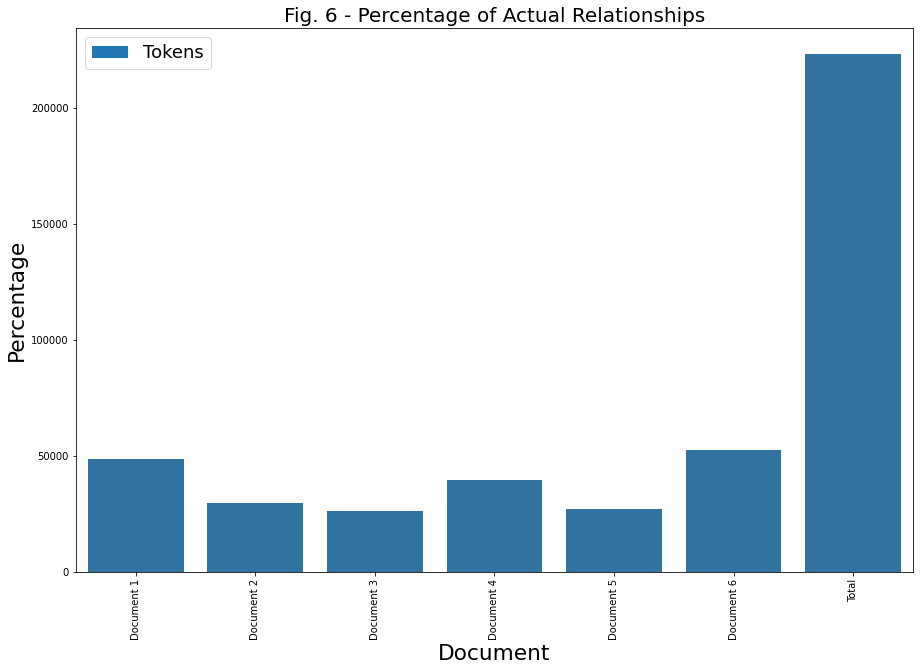

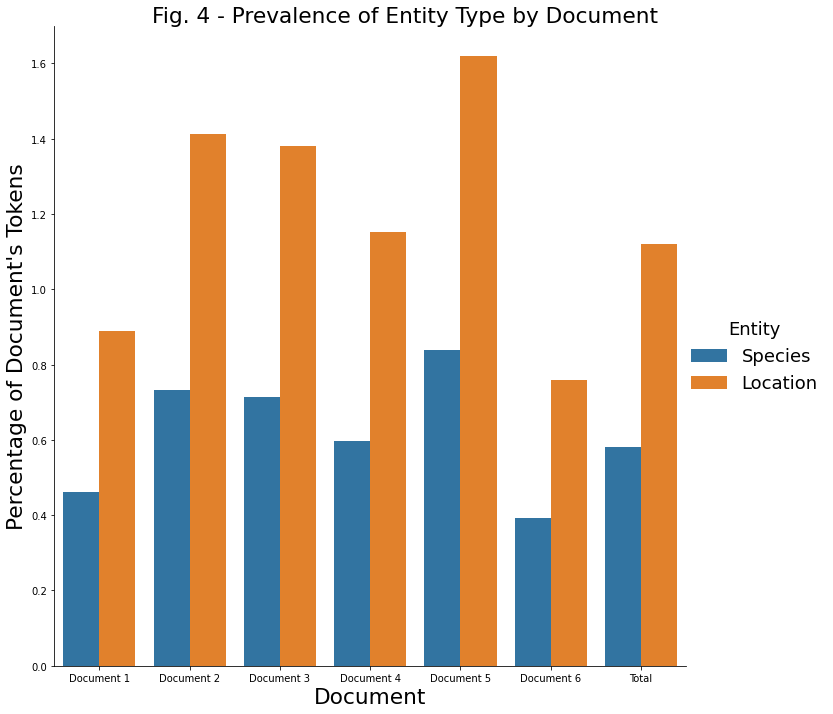

In [8]:
# Graph of summary of tokens
ax = Summary[0:7].plot.bar(x='DocNum', y='Tokens')
ax.figure.savefig(graphsFolder + '\\SummaryOfTokens')

# Graph of summary tokens in documents
ax = sns.barplot(x='DocNum', y='Tokens', data=Summary[0:7], color='tab:blue')
ax.set_title('Fig. 2 - Length of Documents in Tokens')
ax.set_xlabel('Document')
ax.figure.savefig(graphsFolder + '\\SummaryOfTokensByDocument')

# Graph of summary of sentences in documents
ax = sns.barplot(x='DocNum', y='Sentences', data=Summary[0:7], color='tab:blue')
ax.set_title('Fig. 3 - Length of Documents in Sentences')
ax.set_xlabel('Document')
ax.figure.savefig(graphsFolder + '\\SummaryOfSentencesByDocument')

# Graph of summary of characters in documents
ax = sns.barplot(x='DocNum', y='Characters', data=Summary[0:7], color='tab:blue')
ax.set_title('Length of Documents in Characters')
ax.set_xlabel('Document')
ax.figure.savefig(graphsFolder + '\\SummaryOfCharactersByDocument')

# Graph of summary of actual relationships in documents
ax = sns.barplot(x='DocNum', y='Relationship %', data=Summary, color='tab:orange')
ax.set_title('Fig. 6 - Percentage of Actual Relationships')
ax.set_xlabel('Document')
ax.set_ylabel('Percentage')
ax.figure.savefig(graphsFolder + '\\SummaryOfRelationshipsByDocument')

# Prevalence of entity type by document
ax = sns.catplot(x = 'DocNum', y = 'Vals', hue = 'Entity', data = df, kind = 'bar', height=10)
ax.fig.suptitle('Fig. 4 - Prevalence of Entity Type by Document', y=1)
ax.set_axis_labels("Document", "Percentage of Document's Tokens")
ax.figure.savefig(graphsFolder + '\\SummaryOfEntityPrevalenceByDocument')

End.